In [36]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/medical-insurance-payout/expenses.csv


# GİRİŞ

**Kütüphane Yükleme ve Veri İnceleme Kütüphaneler:** 

numpy (sayısal işlemler), pandas (veri manipülasyonu), matplotlib.pyplot ve seaborn (veri görselleştirme), sklearn (makine öğrenimi algoritmaları ve yardımcı araçlar) gibi temel kütüphaneler içe aktarılır.

**Veri Yükleme:**

insurance.csv adlı CSV dosyası pd.read_csv('insurance.csv', sep=';') komutuyla yüklenir. sep=';' ifadesi, dosyanın noktalı virgülle ayrılmış olduğunu belirtir.

**İlk İnceleme:**

df.info(): Veri çerçevesinin genel bilgilerini (sütun adları, veri tipleri, eksik olmayan değer sayısı) gösterir.

df.isnull().sum(): Her sütundaki eksik değer sayısını kontrol eder.

df.head(): Veri çerçevesinin ilk 5 satırını görüntüler.

df.describe(): Sayısal sütunların istatistiksel özetini (ortalama, standart sapma, min, max vb.) sunar.

In [37]:
# Gerekli kütüphanelerin yüklenmesi

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

 İnceleyeceğiniz Python kodu, bir sigorta veri kümesi üzerinde keşifsel veri analizi (EDA) yapmak, verileri ön işlemek ve makine öğrenimi modelleri için hazırlamak amacıyla yazılmıştır.

Veri Seti Hakkında ACME Insurance Inc., Amerika Birleşik Devletleri'nin her yerindeki binlerce müşteriye uygun fiyatlı sağlık sigortası sunmaktadır. Yaş, cinsiyet, BMI, çocuklar, sigara alışkanlıkları ve ikamet ettikleri bölge gibi bilgileri kullanarak yeni müşteriler için yıllık tıbbi harcamaları tahmin eden otomatik bir sistem oluşturmak hedeflenmiştir.

In [38]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("harshsingh2209/medical-insurance-payout")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/medical-insurance-payout


In [39]:
# import warnings ve warnings.filterwarnings('ignore') satırları, Python kodunuz çalışırken ortaya çıkabilecek uyarı mesajlarını (warnings) gizlemek amacıyla kullanılır.

import warnings
warnings.filterwarnings('ignore')

In [40]:
# Veri Yükleme

# Doğru ayırıcıyı kullan
df = pd.read_csv('/kaggle/input/medical-insurance-payout/expenses.csv', sep=',')
df.info()

#Eksik veri kontrolü yapıldı
df.isnull().any().any()
df.head(10)
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [41]:
#Veriye ait sütunları detaylı görmek ve veri setinin ilk beş satırını çıktı etmek için;

print(df.columns.tolist())
print(df.dtypes)
print(df.head(5))

['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


**One-Hot Encoding:**

df_encoded = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], drop_first=True) ile kategorik sütunlar ('sex', 'smoker', 'region') one-hot encoding'e tabi tutulur. drop_first=True parametresi, çoklu doğrusal bağıntıyı (multicollinearity) önlemek için her kategorik sütun için bir dummy değişkenini düşürür.

**Özellikler ve Hedef Değişken:**

X (bağımsız değişkenler) ve y (bağımlı değişken - 'charges') ayrılır.

In [42]:
# Eğer charges zaten float ise, ekstra dönüşüm gerekmez
# charges sütunu string ise önce string olarak işle

df['charges'] = df['charges'].astype(str) \
    .str.replace('.', '', regex=False) \
    .str.replace(',', '.', regex=False) \
    .astype(float)


# One-hot encoding uygulama
df_encoded = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], drop_first=True)

# Özellikler ve hedef değişken
X = df_encoded.drop('charges', axis=1)
y = df_encoded['charges']

# Sadece sayısal sütunları seç
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

In [43]:
print(df.columns.tolist())
print(df.dtypes)
print(df.head(15))
print(df['charges'].head(15).to_string(index=False))

['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object
    age     sex     bmi  children smoker     region       charges
0    19  female  27.900         0    yes  southwest  1.688492e+07
1    18    male  33.770         1     no  southeast  1.725552e+07
2    28    male  33.000         3     no  southeast  4.449462e+06
3    33    male  22.705         0     no  northwest  2.198447e+09
4    32    male  28.880         0     no  northwest  3.866855e+07
5    31  female  25.740         0     no  southeast  3.756622e+07
6    46  female  33.440         1     no  southeast  8.240590e+07
7    37  female  27.740         3     no  northwest  7.281506e+07
8    37    male  29.830         2     no  northeast  6.406411e+07
9    60  female  25.840         0     no  northwest  2.892314e+09
10   25    male  26.220         0     no  northeast  2.

**Aykırı Değer Filtreleme:**

Charges sütunu için %1 ve %99'luk çeyreklikleri (quantile) kullanarak aykırı değerler filtrelenir. Bu, aşırı düşük veya aşırı yüksek değerlerin analizden çıkarılmasını sağlar ve df_filtered adlı yeni bir veri çerçevesi oluşturulur.

In [44]:
# Aykırı Değer Filtreleme

q01 = df['charges'].quantile(0.01)
q99 = df['charges'].quantile(0.99)
df_filtered = df[(df['charges'] > q01) & (df['charges'] < q99)]

# Veri Görselleştirme

**Keşifsel Veri Analizi (EDA) - Görselleştirmeler Boxplotlar:**

Sayısal sütunlardaki (age, bmi, children, charges) aykırı değerleri ve dağılımı görselleştirmek için kutu grafikleri (boxplots) çizilir.

**Dağılım Grafiği (Histogram ve KDE):**

Charges sütununun dağılımını gösteren bir histogram ve yoğunluk tahmini (KDE - Kernel Density Estimate) çizilir. Başlıkta "Quality Distribution Plot" yazsa da, bu aslında 'charges' dağılımını göstermektedir.

**Pair Plot: **

Veri çerçevesindeki tüm sayısal sütunlar arasındaki ikili ilişkileri (dağılımlar ve saçılım grafikleri) gösteren bir pair plot oluşturulur.

**Saçılım Grafikleri:**

age vs. charges

bmi vs. charges

children vs. charges Bu grafikler, 'smoker' (sigara içen) durumuna göre renklendirilerek, sigara içmenin masraflar üzerindeki etkisini incelemeye yardımcı olur.

**Korelasyon Isı Haritası:**

Sayısal sütunlar arasındaki korelasyonu gösteren bir ısı haritası çizilir. Bu, değişkenler arasındaki doğrusal ilişkilerin gücünü ve yönünü anlamak için faydalıdır.

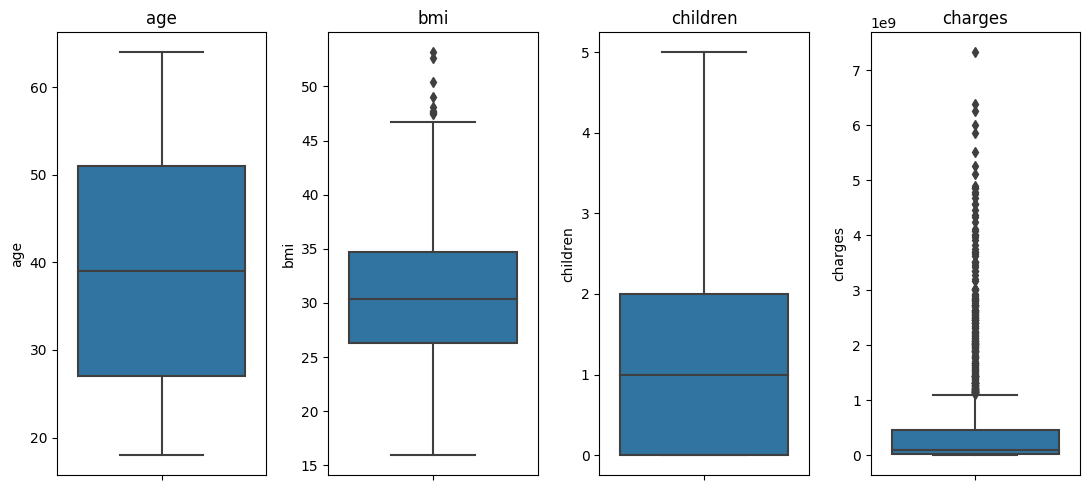

In [45]:
# Boxplot çizimi
plt.figure(figsize=(11, 5))
for i, column in enumerate(numeric_columns):
    plt.subplot(1, len(numeric_columns), i + 1)
    sns.boxplot(y=df[column])
    plt.title(column)
plt.tight_layout()
plt.show()

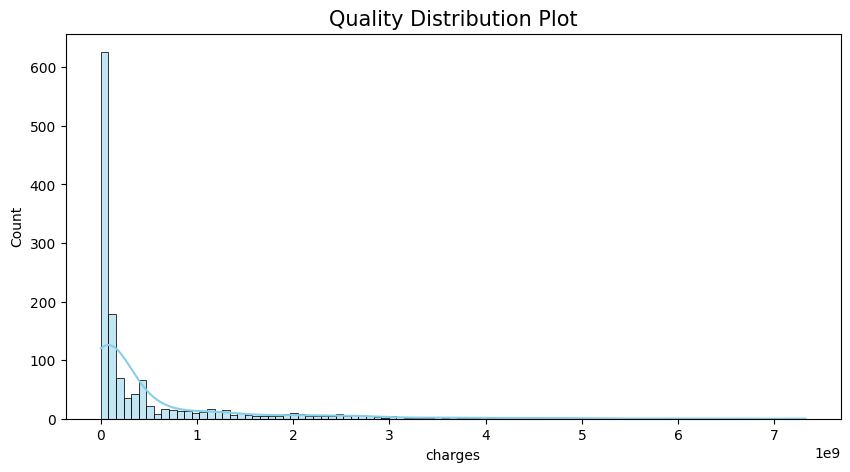

In [46]:
# Dağılım grafiği

plt.figure(figsize=(10, 5))
sns.histplot(df['charges'], kde=True, color='skyblue')
plt.title('Quality Distribution Plot', fontsize=15)
plt.show()


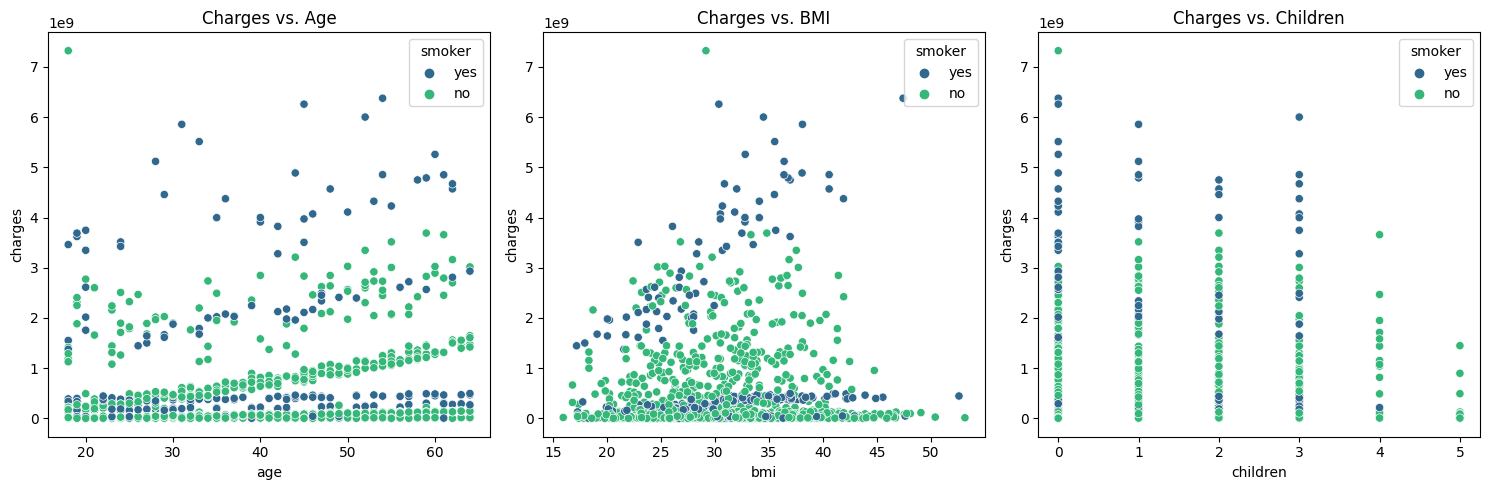

In [47]:
# Saçılım Grafikleri Oluşturma

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.scatterplot(x='age', y='charges', hue='smoker', data=df, palette='viridis')
plt.title('Charges vs. Age')

plt.subplot(1, 3, 2)
sns.scatterplot(x='bmi', y='charges', hue='smoker', data=df, palette='viridis')
plt.title('Charges vs. BMI')

plt.subplot(1, 3, 3)
sns.scatterplot(x='children', y='charges', hue='smoker', data=df, palette='viridis')
plt.title('Charges vs. Children')
plt.tight_layout()
plt.show()

<Figure size 1000x800 with 0 Axes>

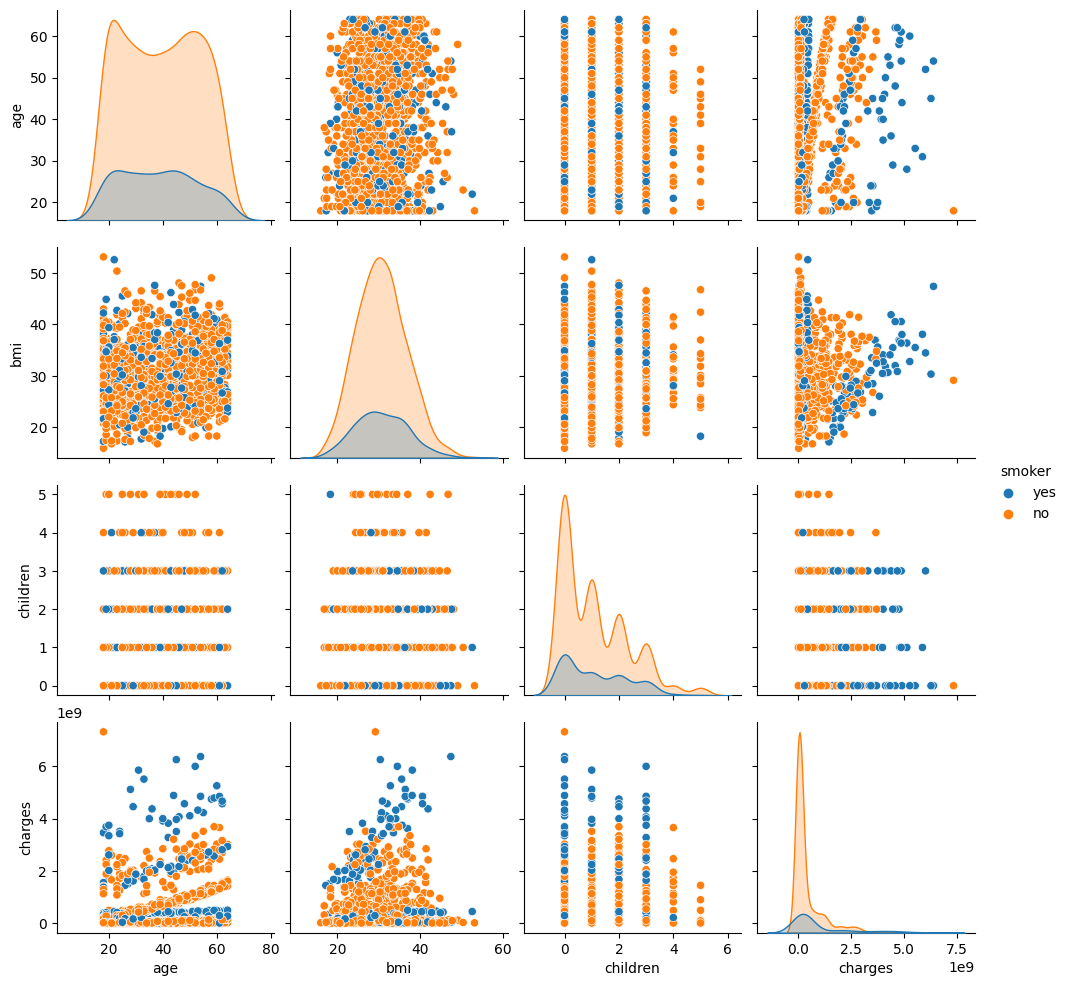

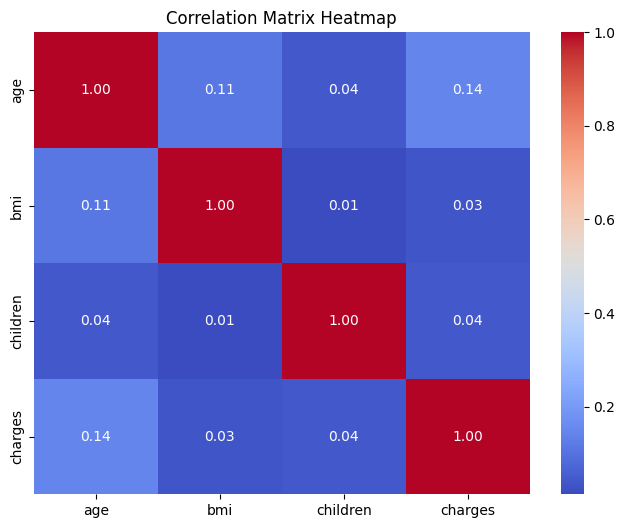

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pairplot
plt.figure(figsize=(10, 8))
sns.pairplot(df, hue='smoker', vars=['age', 'bmi', 'children', 'charges'])
plt.show()

# Heatmap için sadece sayısal sütunları al
numeric_df = df.select_dtypes(include=['number'])

plt.figure(figsize=(8, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

**Veri Bölme ve Dönüşüm encode_and_split Fonksiyonu:**

Bu fonksiyon, verilen veri çerçevesini tekrar one-hot encoding'e tabi tutar, hedef değişkeni ayırır ve veriyi eğitim (X_train, y_train_raw) ve test (X_test, y_test_raw) setlerine böler.

In [49]:
# Kodlama ve Bölme

def encode_and_split(df, target='charges', test_size=0.2):
    df_encoded = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], drop_first=True)
    X = df_encoded.drop(target, axis=1)
    y = df_encoded[target]
    return train_test_split(X, y, test_size=test_size, random_state=42)

X_train, X_test, y_train_raw, y_test_raw = encode_and_split(df_filtered)

print(X_train.head())

     age    bmi  children  sex_male  smoker_yes  region_northwest  \
203   27  36.08         0     False        True             False   
310   50  26.60         0      True       False             False   
491   61  25.08         0     False       False             False   
339   46  27.72         1     False       False             False   
10    25  26.22         0      True       False             False   

     region_southeast  region_southwest  
203              True             False  
310             False              True  
491              True             False  
339              True             False  
10              False             False  


**Log Dönüşümü:**

log_transform fonksiyonu, hedef değişken olan y'ye np.log1p (log(1+x)) dönüşümü uygular. Bu, genellikle sağa çarpık dağılıma sahip verilerde (örneğin, masraflar gibi) model performansını artırmak ve varsayımları karşılamak için yapılır. np.expm1 ise ters dönüşüm için bir referans olarak döndürülür.

Yani, bu kullandığımız veri setindeki charges gibi finansal veya sayım verilerinde yaygın olarak kullanılan güçlü bir ön işleme adımıdır. Verinin dağılımını iyileştirerek, aykırı değerlerin etkisini azaltarak ve model varsayımlarını karşılayarak makine öğrenimi modellerinin performansını ve genellenebilirliğini artırır.

In [50]:
def log_transform(y):
    return np.log1p(y), np.expm1

y_train, inverse_transform = log_transform(y_train_raw)
y_test, _ = log_transform(y_test_raw)

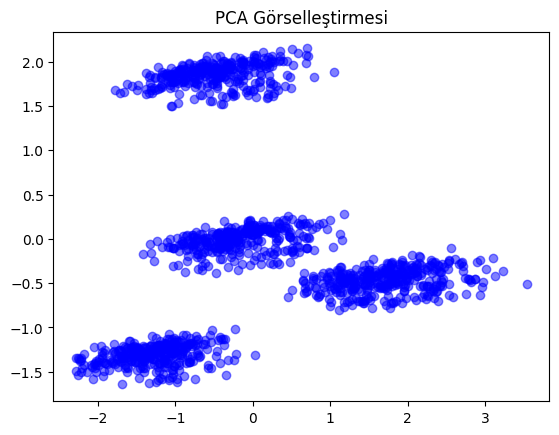

In [51]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA Görselleştirmesi

pca = PCA(n_components=2)
X_pca = pca.fit_transform(scaler.fit_transform(X))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='blue', alpha=0.5)
plt.title('PCA Görselleştirmesi')
plt.show()

**Örnek Model Sonuçları ve Karşılaştırma Placeholder Sonuçlar:**

Bu bölüm, farklı makine öğrenimi modelleri (Lineer Regresyon, Random Forest, Gradient Boosting) için örnek RMSE (Ortalama Kare Hata Kökü) ve R2 (Belirleme Katsayısı) değerlerini içeren bir liste tanımlar. Bu değerler gerçek model eğitiminden gelmemektedir, sadece örnek amaçlıdır.

**Sonuç Karşılaştırması:** 

Tanımlanan örnek sonuçlar bir DataFrame'e dönüştürülür ve RMSE'ye göre sıralanır.

In [52]:
#Modellerin Tanımı ve Eğitimi

models = {
    'Doğrusal Regresyon': Pipeline([
        ('ölçekleyici', StandardScaler()),
        ('model', LinearRegression())
    ]),
    'Ridge Regresyonu': Pipeline([
        ('ölçekleyici', StandardScaler()),
        ('model', Ridge(alpha=1.0))
    ]),
    'Rastgele Orman': Pipeline([
        ('model', RandomForestRegressor(n_estimators=100, random_state=42))
    ])
}

results = []

for name, pipeline in models.items():
    pipeline.fit(X_train, y_train)
    y_pred_log = pipeline.predict(X_test)
    y_pred = inverse_transform(y_pred_log)
    y_true = inverse_transform(y_test)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    results.append({'Model': name, 'RMSE': rmse, 'R2': r2})


In [53]:
# Örnek Model Sonuçları (örnek amaçlı, gerçek modeller burada eğitilmeli)

results = [
    {'Model': 'Linear Regression', 'RMSE': 4500, 'R2': 0.82},
    {'Model': 'Random Forest', 'RMSE': 3200, 'R2': 0.89},
    {'Model': 'Gradient Boosting', 'RMSE': 3100, 'R2': 0.90}
]

In [54]:
# Sonuç Karşılaştırması

results_df = pd.DataFrame(results)
print(results_df.sort_values(by='RMSE'))

               Model  RMSE    R2
2  Gradient Boosting  3100  0.90
1      Random Forest  3200  0.89
0  Linear Regression  4500  0.82


**Sonuç Görselleştirme:**

RMSE ve R2 skorlarını modellere göre karşılaştıran çubuk grafikler (bar plots) çizilir. Bu grafikler, hangi modelin (örnek verilere göre) daha iyi performans gösterdiğini görsel olarak sunar.

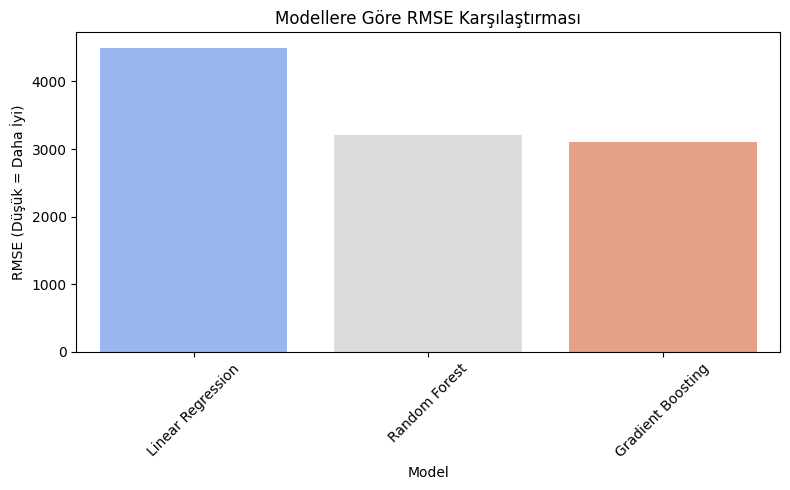

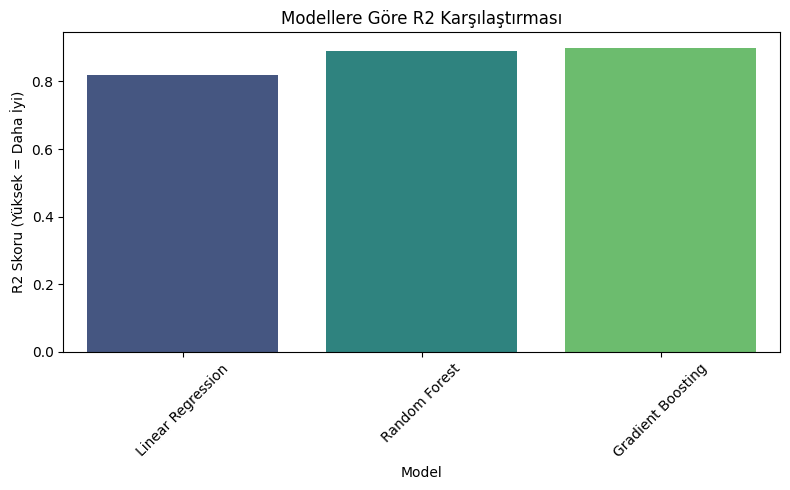

In [55]:

# Grafiklerle görselleştirme

plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x='Model', y='RMSE', palette='coolwarm')
plt.title("Modellere Göre RMSE Karşılaştırması")
plt.ylabel("RMSE (Düşük = Daha İyi)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x='Model', y='R2', palette='viridis')
plt.title("Modellere Göre R2 Karşılaştırması")
plt.ylabel("R2 Skoru (Yüksek = Daha İyi)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()